# Class Exercise - MCTS with TSP
- Tal Zilkha - tiz2102
- Mat Hillman - mh3691

# MCTS

In [1204]:
import math
import numpy as np
EPS = 1e-8
import copy

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}       # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}       # stores #times edge s,a was visited
        self.Ns = {}        # stores #times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores game.getGameEnded ended for board s
        self.Vs = {}        # stores game.getValidMoves for board s
        
        self.val = [float('inf')]
        self.num_sim = [0]

    def getActionProb(self, state, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(state, i)

        s = self.game.stringRepresentation(state[-1])
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
        
        if temp==0:
            bestA = np.argmax(counts)
            probs = [0]*len(counts)
            probs[bestA]=1
            return probs

        counts = [x**(1./temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x/counts_sum for x in counts]
        return probs


    def search(self, state, num_sim):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(state[-1])
        
        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(state[-1])
        if self.Es[s]!=0:
            # terminal node
            return 0

        if s not in self.Ps:
            # leaf node
            if self.nnet is not None:
                if args['history']:
                    self.Ps[s], v = self.nnet.predict(state, self.game.graph)
                else:
                    self.Ps[s], v = self.nnet.predict(state[-1], self.game.graph)
            else:
                self.Ps[s] = np.ones(self.game.getActionSize()) # random policy
                v = 0
            valids = self.game.getValidMoves(state[-1])
            self.Ps[s] = self.Ps[s]*valids      # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s    # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable
                
                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, do workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s,a) in self.Qsa:
                    u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
                else:
                    u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s] + EPS)     # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, reward = self.game.getNextState(state[-1], a)
        new_history = copy.deepcopy(state)
        new_history.append(next_s)
        
        v = self.search(new_history, num_sim) + reward

        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1)
            self.Nsa[(s,a)] += 1

        else:
            self.Qsa[(s,a)] = v
            self.Nsa[(s,a)] = 1
            
        if self.game.getActionSize() - self.val[-1] < v:
            self.val += [self.game.getActionSize() - v]
            self.num_sim += [num_sim]

        self.Ns[s] += 1
        return v

# TSPGame

In [1205]:
from itertools import permutations 

class TSPGame():
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.
    Use 1 for player1 and -1 for player2.
    See othello/OthelloGame.py for an example implementation.
    """
    def __init__(self, args):
        self.num_node = args.num_node
        self.graph = np.random.rand(self.num_node, 2)

    def getStartState(self):
        """
        Returns:
            start_state: a representation of the graph
        """
        start_state = np.zeros([self.num_node, 2])
        start_state[0,0] = 1
        start_state[0,1] = 1
        return start_state

    def getActionSize(self):
        """
        Returns:
            self.num_node: number of all possible actions
        """
        return self.num_node

    def getNextState(self, state, action):
        """
        Input:
            state: current state
            action: action taken by current player
        Returns:
            next_state: graph after applying action
            reward: reward from action
        """
        next_state = state.copy()
        next_state[:, 1] = 0
        next_state[action, :] = 1
        prev_action = np.where(state[:, 1] == 1)[0][0]
        prev_node = self.graph[prev_action]
        cur_node = self.graph[action]
        reward = 1 - np.linalg.norm(cur_node - prev_node)
        if self.num_node == np.sum(next_state[:, 0]):
            reward += 1 - np.linalg.norm(cur_node - self.graph[0])
            
        return next_state, reward

    def getValidMoves(self, state):
        """
        Input:
            state: current state
        Returns:
            1 - state[:, 0]: a binary vector of length self.getActionSize(), 1 for
                            moves that are valid from the current board and player,
                            0 for invalid moves
        """
        return 1 - state[:, 0]

    def getGameEnded(self, state):
        """
        Input:
            state: current board state
        Returns:
            r: 0 if game has not ended. 1 if it has
               
        """
        r = 0
        if self.num_node == np.sum(state[:, 0]):
            r = 1
        return r

    def stringRepresentation(self, state):
        """
        Input:
            state: current state
        Returns:
            s: string representation of state
        """
        s = ''
        for i in range(self.num_node):
            s += str(int(state[i, 0]))
        return s
    
    def optimal_sol(self):
        """
        Input:
            
        Returns:
            optimal_val: optimal solution for TSP
            optimal_path: optimal path for TSP
        """
        cur_reward = 0
        optimal_val = float('inf')
        optimal_path = []
        graph = self.graph

        nodes = np.arange(self.num_node)[1:]
        perms = permutations(nodes)
        
        for perm in list(perms):
            cur_reward = 0
            
            cur_reward += np.linalg.norm(graph[0] - graph[perm[0]])
            for i in range(len(perm) - 1):
                j = perm[i]
                k = perm[i+1]
                cur_reward += np.linalg.norm(graph[k] - graph[j])
            cur_reward += np.linalg.norm(graph[perm[-1]] - graph[0])
            
            if optimal_val > cur_reward:
                optimal_val = cur_reward
                optimal_path = perm
        
        return optimal_val, optimal_path
    
    def create_sample(self):
        path = self.optimal_sol()[1]+tuple([0])
        current = self.getStartState()
        samples_v = []
        samples_pi = []
        tot_v = 0
        for i in path:
            pi = np.zeros(self.getActionSize())
            pi[i] = 1
            samples_pi.append((current, pi))
            next, v = self.getNextState(current, i)
            samples_v.append((current, v))
            current = next
        
        return samples_v, samples_pi
        
        

# Configuration

In [1206]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    # State representation
    'history': True,           # Whether state representation should be a history of states - used for lstm
    'history_length': None,     # If None full history
    
    # MCTS args
    'numMCTSSims': 5000,        # Number of games moves for MCTS to simulate.
    'num_node': 5,              # Number of nodes in the graph (game)
    
    # Train args
    'numIters': 1,              # Number of episods to play (5 times 10 episodes)
    'numEps': 1,                # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'numItersForTrainExamplesHistory': 25,
    
    # NN args
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 200,
    'batch_size': 64,
    'cuda': False,
    'num_channels': 512,
    })

# Self Play

In [1207]:
def play_game(args):
    game = TSPGame(args)
    mcts = MCTS(game, None, args)
    state = [game.getStartState()]
    mcts_reward = 0
    mcts_actions = []
    optimal_val, optimal_path = game.optimal_sol()
    while not game.getGameEnded(state[-1]):
        action = np.argmax(mcts.getActionProb(state))
        next_state, reward = game.getNextState(state[-1], action)
        state.append(next_state)
        mcts_actions += [action]
        mcts_reward += reward
        
#     print('Optimal Solution:', optimal_val)
#     print('Optimal Action:', optimal_path)
#     print('MCTS Reward:', game.getActionSize() - mcts_reward)
#     print('MCTS Action:', mcts_actions)
    
    return mcts.val, mcts.num_sim, optimal_val

# Plot

In [1208]:
val, num_sim, optimal_reward = play_game(args)
print(num_sim, val)

[0, 1, 2, 3, 4, 11] [inf, 4.181742167634327, 3.9848065043247507, 3.4106279845576277, 3.138840267489805, 2.8715864803856066]


Text(0,0.5,'Length')

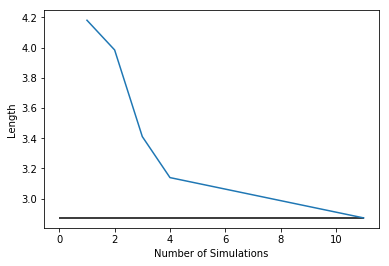

In [1209]:
import matplotlib.pyplot as plt

plt.plot(np.array(num_sim[1:]), val[1:])
plt.hlines(optimal_reward, 0, num_sim[-1])
plt.xlabel("Number of Simulations")
plt.ylabel("Length")

In [1210]:
from collections import deque
import time, os, sys
from pickle import Pickler, Unpickler
from random import shuffle


class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
#         self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []    # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False    # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard,pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = [self.game.getStartState()]
#         self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(board, temp=temp)

            action = np.random.choice(len(pi), p=pi)
            next_board, reward = self.game.getNextState(board[-1], action)
            
            trainExamples.append([board, self.game.graph, pi, reward])
            
            board.append(next_board)
            
            r = self.game.getGameEnded(board[-1])
            
            if r!=0:
                return [tuple(x) for x in trainExamples]
            
#             board = next_board

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        for i in range(1, self.args.numIters+1):
            # bookkeeping
#             print('------ITER ' + str(i) + '------')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i>1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for eps in range(self.args.numEps):
                    self.mcts = MCTS(self.game, self.nnet, self.args)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                self.trainExamplesHistory.append(iterationTrainExamples)
                
            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                print("len(trainExamplesHistory) =", len(self.trainExamplesHistory), " => remove the oldest trainExamples")
                self.trainExamplesHistory.pop(0)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)
            
            # train
            # self.nnet.train(trainExamples)
        return trainExamples


In [1211]:
import sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [1212]:
# Inputs are in the form of a merged matrix of the graph and board

class ConvolutionalNN():
    def __init__(self, args):
        self.action_size = args['num_node']
        self.create_net()
        # Conv no history
        self.args = args
        self.args['history'] = False

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, input_graphs, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray([boards[-1] for boards in input_boards])
        input_graphs = np.asarray(input_graphs)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        
        boards_graphs_list = [(input_graphs[i], input_boards[i]) for i in range(0, len(input_boards))] 
        input = [np.concatenate([*i], axis=1) for i in boards_graphs_list]
        self.model.fit(x = [input], y = [target_pis, target_vs], 
                       batch_size = args.batch_size, epochs = args.epochs, verbose=1)

    def predict(self, board, graph):
        """
        board: np array with board
        """        
        merged = np.concatenate([graph, board], axis=1)
        merged = merged[np.newaxis, :, :]
        
        # run
        pi, v = self.model.predict(merged)
        return pi[0], v[0]
    
    def create_net(self):
        # Neural Net
        self.input_boards = Input(shape=(self.action_size, 4))    # s: batch_size x board_x x board_y

        x_image = Reshape((self.action_size, 4, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
        h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
        h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
        h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
        h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
        h_conv4_flat = Flatten()(h_conv4)       
        s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
        s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
        self.v = Dense(1, activation='relu', name='v')(s_fc2)                    # batch_size x 1

        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))

In [1213]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

class RecurrentNN():
    def __init__(self, args):
        # game params
        self.action_size = args['num_node']
        self.num_node = args['num_node']
        self.board_size = (args['num_node'],2)
        self.args = args
        self.create_net()
        # Conv no history
        self.args['history'] = True
        
    def create_net(self):
        self.input_boards = Input(shape=(self.num_node, self.num_node*4))
        lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(self.input_boards)
        dense = Dense(128, activation='sigmoid')(lstm)
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(dense)
        self.v = Dense(1, activation='relu', name='v')(dense)
        
        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))        

    def predict(self, board_list, graph):
        input = self.prepare_input(board_list,graph)
        pi, v = self.model.predict(input)


        #print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return pi[0], v[0]
    
    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, input_graphs, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        input_graphs = np.asarray(input_graphs)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        boards_graphs_list = [(input_boards[i], input_graphs[i]) for i in range(0, len(input_boards))] 
        prepared_inputs = np.asarray([self.prepare_input(*i)[0] for i in boards_graphs_list])
        self.model.fit(x = [prepared_inputs], y = [target_pis, target_vs], 
                       batch_size = args.batch_size, epochs = args.epochs, verbose=1)

    #
    # State representation is a history of states with the graph appended to them and the whole thing shaped to array.
    #
    #      [graph, visited, camefrom]  t0
    #      [graph, visited, camefrom]  t1
    #      [graph, visited, camefrom]  t2
    #      ..
    #      ..
    #      [graph, visited, camefrom]  tn
    #
    # Where tn is the current state and any timestamp that came before the first move is as such
    #      
    #      [graph,0,0]
    #
    
    def prepare_input(self,board_list, graph):
        if self.args['history_length'] is None:
            self.args['history_length'] = self.num_node
        while len(board_list)<self.args['history_length']:
            board_list = [np.zeros(self.board_size)] + board_list
        board_list = [x.transpose() for x in board_list]
        input = np.array(board_list).reshape(len(board_list), self.num_node*2)
        [graph]*self.num_node
        graph_data = np.array(([np.array(graph).reshape(self.num_node*2)]*len(board_list))).reshape(len(board_list), self.num_node*2)
        input = np.stack((np.array(graph_data), np.array(input)), axis=1).reshape(1,self.num_node,self.num_node*4)
        return(input)
    

In [1198]:
def play_game_with_nn(args, nn):
    game = TSPGame(args)
    mcts = MCTS(game, nn, args)
    state = game.getStartState()
    mcts_reward = 0
    mcts_actions = []
    optimal_val, optimal_path = game.optimal_sol()
    
    while not game.getGameEnded(state):
        action = np.argmax(mcts.getActionProb(state))
        state, reward = game.getNextState(state, action)
        mcts_actions += [action]
        mcts_reward += reward
        
#     print('Optimal Solution:', optimal_val)
#     print('Optimal Action:', optimal_path)
#     print('MCTS Reward:', game.getActionSize() - mcts_reward)
#     print('MCTS Action:', mcts_actions)
    
    return mcts.val, mcts.num_sim, optimal_val

In [1214]:
# build training dataset
def create_training_set(args, n_games = 100):
    data_set = []
    for i in range(n_games):
        t = TSPGame(args)
        train_v, train_pi = t.create_sample()
        for i in range(1,len(train_v)+1):
            boards = [j[0] for j in train_v[:i]]
            graph = t.graph
            data_set+=[(boards, graph, train_pi[i-1][1], train_v[i-1][1])]
    return data_set
            
dataset = create_training_set(args, 3000)

In [1216]:
rnn = RecurrentNN(args)
rnn.train(dataset)

Training...
Epoch 1/200
 5824/15000 [==========>...................] - ETA: 58s - loss: 1.9606 - pi_loss: 1.3538 - v_loss: 0.6068

KeyboardInterrupt: 